In [1]:
### This jupyter notebook is owned by Kai-Chun Lin
### The codes below are inspired by https://qiskit.org/documentation/optimization/tutorials/index.html#

In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
import random
import cplex
import gurobipy as gp
import time
import matplotlib.pyplot as plt

# docplex

In [2]:
model = Model('LP-model')

In [3]:
x1 = model.binary_var("x1")
x2 = model.binary_var("x2")
x3 = model.binary_var("x3")
x4 = model.binary_var("x4")
x5 = model.binary_var("x5")


In [4]:
model.maximize((0-random.randrange(10))*x1+
               (0-random.randrange(10))*x2+
               (0-random.randrange(10))*x3+
               (0-random.randrange(10))*x4+
               (0-random.randrange(10))*x5)

In [5]:
model.add_constraint(x1+x2+x3+x4+x5==3)
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: LP-model

Maximize
 obj: - 2 x1 - 4 x2 - 3 x3 - 6 x4 - 5 x5
Subject To
 c1: x1 + x2 + x3 + x4 + x5 = 3

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x1 x2 x3 x4 x5
End



In [6]:
start = time.time()
model.solve()
seconds1 = time.time() - start
milli1 = seconds1*1000
print(milli1) # milliseconds

8.04758071899414


In [7]:
model.solution

docplex.mp.solution.SolveSolution(obj=-9,values={x1:1,x2:1,x3:1})

# QAOA

In [8]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.converters import QuadraticProgramToQubo


In [9]:
quadratic_model = from_docplex_mp(model)
print(quadratic_model.prettyprint())

Problem name: LP-model

Maximize
  -2*x1 - 4*x2 - 3*x3 - 6*x4 - 5*x5

Subject to
  Linear constraints (1)
    x1 + x2 + x3 + x4 + x5 == 3  'c0'

  Binary variables (5)
    x1 x2 x3 x4 x5



In [10]:
cov = QuadraticProgramToQubo()
qubo = cov.convert(quadratic_model)
print(qubo.prettyprint())

Problem name: LP-model

Minimize
  21*x1^2 + 42*x1*x2 + 42*x1*x3 + 42*x1*x4 + 42*x1*x5 + 21*x2^2 + 42*x2*x3
  + 42*x2*x4 + 42*x2*x5 + 21*x3^2 + 42*x3*x4 + 42*x3*x5 + 21*x4^2 + 42*x4*x5
  + 21*x5^2 - 124*x1 - 122*x2 - 123*x3 - 120*x4 - 121*x5 + 189

Subject to
  No constraints

  Binary variables (5)
    x1 x2 x3 x4 x5



In [11]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 41.5
operator:
9.5 * IIIIZ
+ 8.5 * IIIZI
+ 9.0 * IIZII
+ 7.5 * IZIII
+ 8.0 * ZIIII
+ 10.5 * IIIZZ
+ 10.5 * IIZIZ
+ 10.5 * IIZZI
+ 10.5 * IZIIZ
+ 10.5 * IZIZI
+ 10.5 * IZZII
+ 10.5 * ZIIIZ
+ 10.5 * ZIIZI
+ 10.5 * ZIZII
+ 10.5 * ZZIII


######

In [12]:
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [13]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [14]:
start = time.time()
exact_result = exact.solve(qubo)
seconds2 = time.time() - start
milli2 = seconds2 *1000
print(milli2) # milliseconds
print(exact_result.prettyprint())

40.126800537109375
objective function value: 9.0
variable values: x1=1.0, x2=1.0, x3=1.0, x4=0.0, x5=0.0
status: SUCCESS


In [15]:
start = time.time()
qaoa_result = qaoa.solve(qubo)
seconds3 = time.time() - start
milli3 = seconds3 *1000
print(milli3) # milliseconds
print(qaoa_result.prettyprint())

3385.7429027557373
objective function value: 9.0
variable values: x1=1.0, x2=1.0, x3=1.0, x4=0.0, x5=0.0
status: SUCCESS


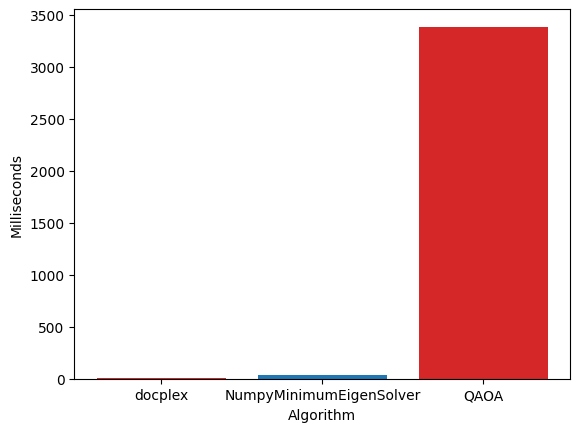

<Figure size 1500x1000 with 0 Axes>

In [16]:
names = ['docplex', 'NumpyMinimumEigenSolver', 'QAOA']
values = [milli1, milli2, milli3]

fig, ax = plt.subplots()
bar_labels = ['red', 'blue', '_red']
bar_colors = ['tab:red', 'tab:blue', 'tab:red']

ax.bar(names, values, label=bar_labels, color=bar_colors)

ax.set_ylabel('Milliseconds')
ax.set_xlabel('Algorithm')
plt.figure(figsize=(15, 10))

#plt.suptitle()
plt.show()